In [3]:
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'

In [4]:
trn = pd.read_csv('aug_train.csv')
tst = pd.read_csv('aug_test.csv')
trn.drop('enrollee_id', axis=1, inplace=True)
tst.drop('enrollee_id', axis=1, inplace=True)
trn['city'] = trn['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))
tst['city'] = tst['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))
print(f"train data size: {trn.shape}, test data size: {tst.shape}")
trn.head(2)

train data size: (19158, 13), test data size: (2129, 12)


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_040,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0


### 데이터설명
빅데이터 분석이나 데이터 사이언스에 관련된 기업은 해당 기업에서 실시하는 교육 과정을 성공적으로 이수한 사람들을 데이터 사이언티스트로 채용하고 싶어합니다. 기업에서는 해당 교육생들이 교육 이수 이후 실제 회사에서 근무할지, 혹은 다른 회사를 알아볼지 알고 싶어합니다. 이 데이터의 목적은 개인의 정보를 바탕으로 이 사람이 교육 후 다른 회사를 알아볼지, 혹은 현 회사에서 근무를 원하는지를 예측하는 것입니다.
- city: 지역코드
- city_development_index: 지역 발전도(?)를 나타낸 수치(정규화)
- gender: 성별
- relevant_experience: 관련업종 경험
- enrolled_university: 대학교육 과정
- education_level: 교육수준
- major_discipline: 전공
- experience: 경력
- company_size: 현재 다니고있는 회사의 총근로자수
- lastnewjob: 현재 직장과 이전 직장의 사이의 기간(년도)
- training_houres: 교육시간
- target: 0 - Not looking for a job change, 1 - Looking for a job change

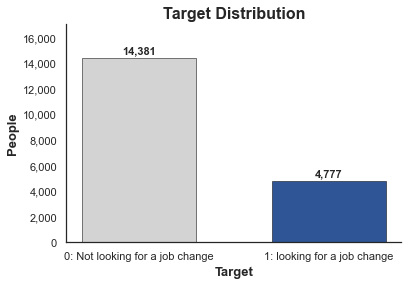

In [5]:
# target 분포 확인
data = trn['target'].value_counts()
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar([0, 1], data.values, width=0.6, color=['lightgrey', '#2f5597'], ec='black', lw=0.5)
for idx in data.index:
    ax.text(idx, data[idx]+200, format(data[idx],","), fontsize=11, fontweight='bold', ha='center', va='bottom')
ax.set_xticks([0, 1])
ax.set_xticklabels(['0: Not looking for a job change', '1: looking for a job change'])
ax.set_yticklabels(list(format(int(x), ",") for x in ax.get_yticks()))
ax.set_ylim(0, 17000)
ax.set_xlabel('Target')
ax.set_ylabel('People')
ax.set_title('Target Distribution')
plt.show()
# 불균형 데이터 입니다. 현재 회사에 다니려고 하는 사람이 옮기려는 사람보다 약 3배 정도 많습니다.

In [6]:
trn_info = pd.concat(
    [
        trn.dtypes,        
        trn.isnull().sum(),
        trn.isnull().sum() / trn.shape[0],
        trn.nunique(),
        tst.nunique()
    ], axis=1
)
trn_info.columns=['data_types', 'Num_of_Null', 'Null_ratio', 'Num_of_unique_values(train)', 'Num_of_unique_values(test)']
trn_info.iloc[:-1, :].style.background_gradient()
# Null값이 상당히 많습니다.

,data_types,Num_of_Null,Null_ratio,Num_of_unique_values(train),Num_of_unique_values(test)
city,object,0,0.000000,123,108.000000
city_development_index,float64,0,0.000000,93,81.000000
gender,object,4508,0.235306,3,3.000000
relevent_experience,object,0,0.000000,2,2.000000
enrolled_university,object,386,0.020148,3,3.000000
education_level,object,460,0.024011,5,5.000000
major_discipline,object,2813,0.146832,6,6.000000
experience,object,65,0.003393,22,22.000000
company_size,object,5938,0.309949,8,8.000000
company_type,object,6140,0.320493,6,6.000000


In [7]:
# 일단 EDA를 위해 모든 Null 값을 Missing으로 처리합니다.
for col in trn.columns:
    trn[col].fillna('Missing', inplace=True)
print(f"이제 Null값은 총 {trn.isnull().sum().sum()}개 입니다")

이제 Null값은 총 0개 입니다


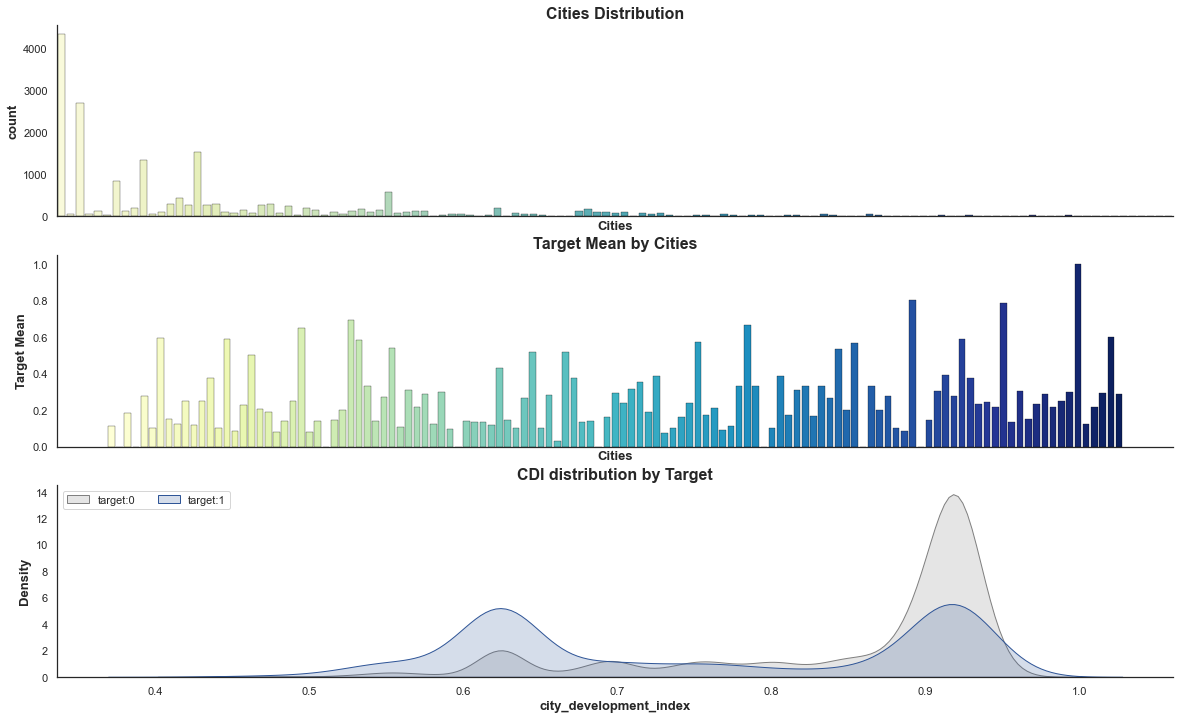

In [8]:
# feature를 하나씩 확인합니다. 먼저 city와 city_development_index 입니다. 둘다 Null값은 없습니다.
# city는 city_001~122총 123개의 고유값이 존재합니다.
fig, axes = plt.subplots(figsize=(20, 12), nrows=3)
sns.countplot(data=trn, x='city', palette='YlGnBu', ec='black', lw=0.3, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_title('Cities Distribution')
axes[0].set_xlabel('Cities')
data = trn.groupby('city')['target'].mean().sort_index()
axes[1].bar(data.index, data.values, color=sns.color_palette('YlGnBu', len(data)), ec='black', lw=0.3)
axes[1].set_xticks([])
axes[1].set_ylabel('Target Mean')
axes[1].set_xlabel('Cities')
axes[1].set_title('Target Mean by Cities')

sns.kdeplot(data=trn[trn.target==0], x='city_development_index', label='target:0', ax=axes[2], fill=True, color='grey', alpha=0.2)
sns.kdeplot(data=trn[trn.target==1], x='city_development_index', label='target:1', ax=axes[2], fill=True, color='#2f5597', alpha=0.2)
axes[2].set_title('CDI distribution by Target')
axes[2].legend(ncol=2, loc='upper left')
plt.show()
# 굉장히 편중된 데이터 입니다.
# 지역에 따라 target이 유의미하게 차이가 있습니다. 특히 몇몇 city의 경우에는 target mean이 0 입니다!
# CDI에 따라서도 target의 분포가 유의미하게 다릅니다.

In [9]:
# 각 city는 하나의 고유한 city_development_index(CDI)를 가지고 있습니다. 
# 그런데 CDI의 고유한 값의 갯수는 city의 고유한 값의 갯수인 123개가 아니라 93개 입니다. 즉 어떠한 도시들은
# CDI 값이 동일할 것입니다.
print(trn.groupby('city')['city_development_index'].nunique().sum() / trn.city.nunique())
data = trn.groupby('city_development_index')['city'].agg(lambda x: list(x.unique())).to_frame()
data['num_cities'] = data['city'].map(lambda x: len(x))
data['num_cities'].value_counts()
print(f"서로다른 CDI 값을 가진 도시는 총 {data[data.num_cities==1].shape[0]}개")
display(data[data.num_cities>1])
# 81개 city는 CDI값이 서로 다릅니다. 그런데 나머지 42개의 도시는 CDI값이 동일하며, 특히나 19개 도시가 모두 동일한 경우도 있습니다

1.0
서로다른 CDI 값을 가진 도시는 총 81개


,city,num_cities
city_development_index,,
0.579,"[city_074, city_078]",2
0.698,"[city_090, city_152, city_150, city_070, city_...",19
0.740,"[city_143, city_053]",2
0.743,"[city_116, city_009]",2
0.776,"[city_040, city_175]",2
0.794,"[city_105, city_037]",2
0.827,"[city_013, city_041]",2
0.847,"[city_080, city_001]",2
0.856,"[city_054, city_069, city_140]",3


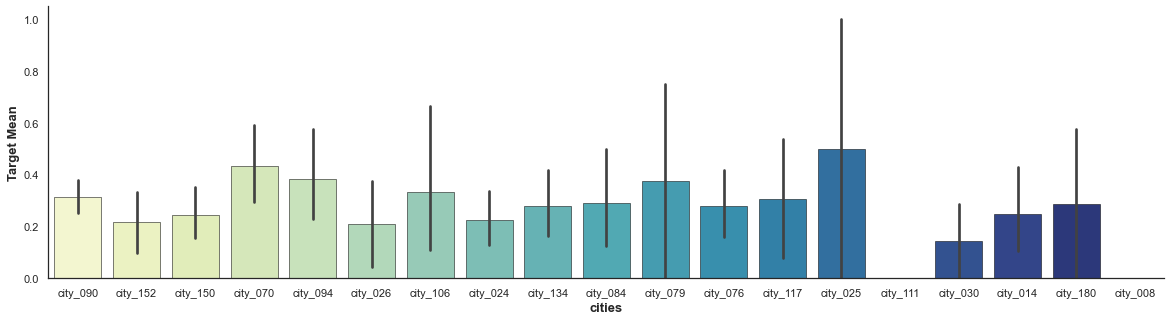

In [10]:
# 동일한 CDI를 가졌으면 동일한 target 분포를 보이는지 확인해보겠습니다.
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=trn[trn.city_development_index==0.698], x='city', y='target', ax=ax, palette='YlGnBu', ec='black', lw=0.5)
ax.set_xlabel('cities')
ax.set_ylabel('Target Mean')
plt.show()
# 동일한 CDI를 가졌어도 city에 따라 다른 Target Mean을 보입니다.(당연한 얘기긴 하지만...)

In [11]:
# categorical feature들을 비슷한 형태의 그래프로 확인하기 위해 먼저 함수를 정의합니다.
def show_categorical_feature(df, feature, order=None, figsize=(15, 4), rotation=0):    
    if order is None:
        order = df[feature].value_counts().index
    data = df[feature].value_counts().loc[order]
    order = order
    fig, axes = plt.subplots(figsize=figsize, ncols=2)
    sns.countplot(data=df, x=feature, palette='YlGnBu', order=order, ax=axes[0], ec='black')
    axes[0].set_yticklabels(list(format(int(y), ",") for y in axes[0].get_yticks()))
    axes[0].set_title(feature + ' Distribution')
    axes[0].set_ylabel('people')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
    axes[0].set_ylim(0, axes[0].get_ylim()[-1] * 1.2)
    for idx in range(len(data)):
        axes[0].text(idx, data[idx]+200, format(int(data[idx]), ","), ha='center', va='bottom', fontsize=11, fontweight='bold')
    sns.barplot(data=df, x=feature, y='target', order=order, ax=axes[1], palette='YlGnBu', ec='black')
    axes[1].set_xlabel(feature)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)
    axes[1].set_ylabel('target mean')
    axes[1].set_title('Target Mean by '+ feature)
    plt.show()

# order list    
gender_order = ['Male', 'Female', 'Other', 'Missing']
major_discipline_order = ['STEM', 'Business Degree', 'Humanities', 'Arts', 'No Major', 'Other', 'Missing']
company_size_order = ['10000+', '5000-9999', '1000-4999', '500-999', '100-500', '50-99', '10/49', '<10', 'Missing']
company_type_order = ['Pvt Ltd', 'Public Sector', 'NGO', 'Funded Startup', 'Early Stage Startup', 'Other', 'Missing']

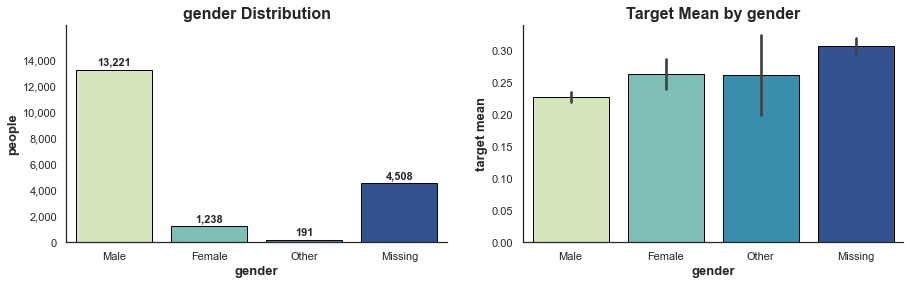

In [12]:
# 이번에 볼 Feature는 gender 입니다. gender는 4508개의 Null값이 존재합니다. 이는 train 데이터 중 약 23.5% 입니다.
show_categorical_feature(trn, 'gender', order=gender_order)
# 대부분 남성이고 Missing 데이터가 상당히 많습니다. Other는 심지어 데이터가 몇개 되지도 않네요..
# Missing의 target mean이 가장 높습니다. Other는 표본이 워낙 적어서 그런지 95% 신뢰구간 범위가 너무 넓습니다.

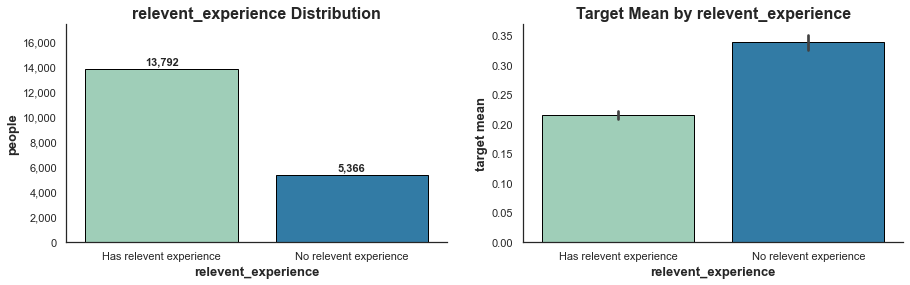

In [13]:
# 다음은 relevent_experience 입니다. 이 feature는 Null이 없습니다.
show_categorical_feature(trn, 'relevent_experience')
# 관련업종 경험이 없으면 다른 직장을 찾을 가능성이 높습니다.

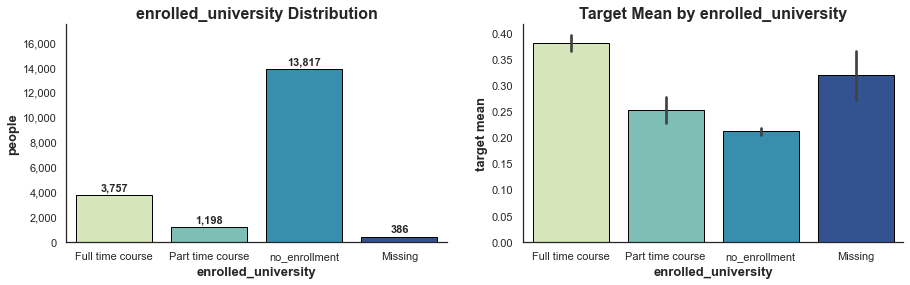

In [14]:
# 다음은 enrolled_university 입니다. 이 feature는 Null 비중이 2.5% 입니다.
show_categorical_feature(trn, 'enrolled_university', ['Full time course', 'Part time course', 'no_enrollment', 'Missing'])
# 학위가 높을수록 이직률이 높습니다. Missing 데이터도 높네요.

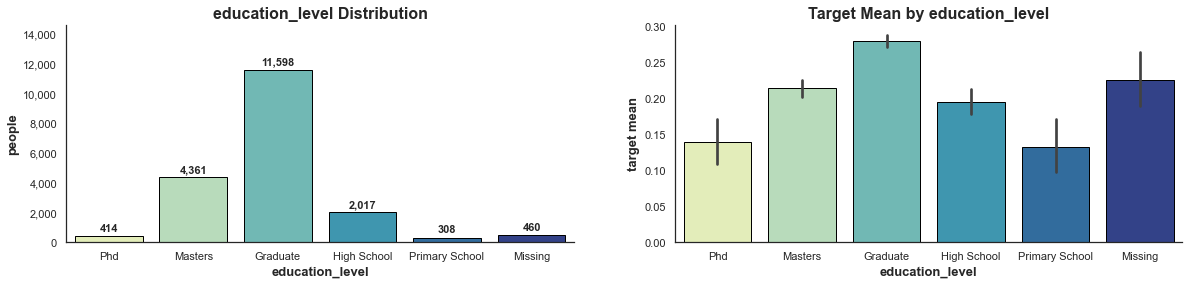

In [15]:
# 다음은 education_level 입니다.
show_categorical_feature(
    trn, 'education_level', ['Phd', 'Masters', 'Graduate', 'High School', 'Primary School', 'Missing'],
    figsize=(20, 4)
)

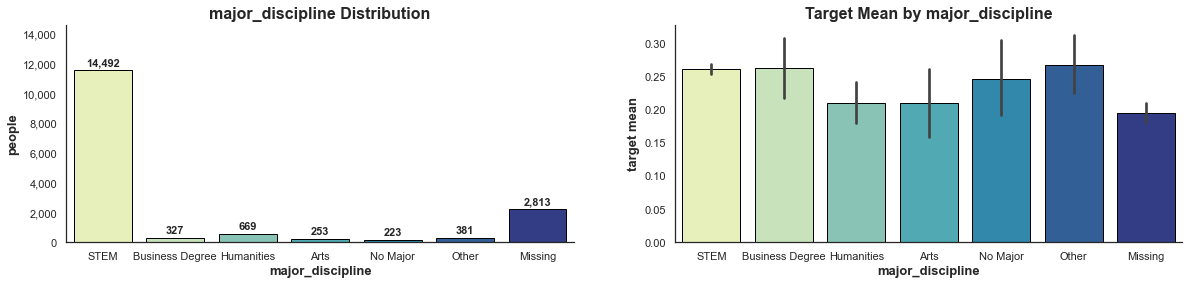

In [16]:
# 다음은 major_discipline 입니다.
show_categorical_feature(
    trn, 'major_discipline', order=major_discipline_order,
    figsize=(20, 4)
)

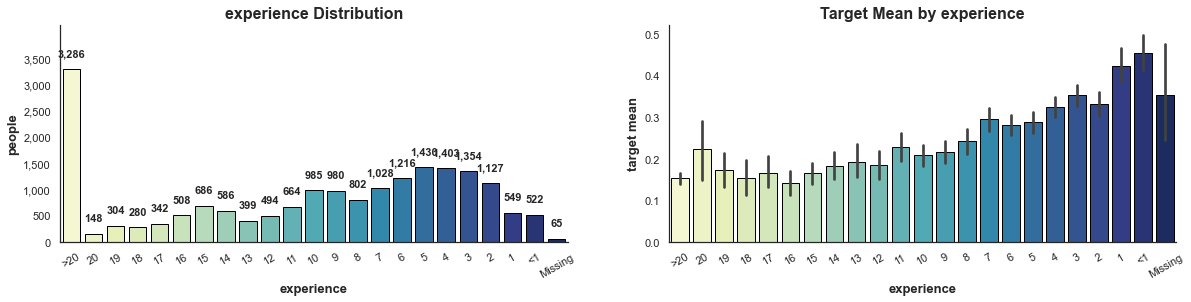

In [17]:
# 다음은 experience 입니다.
show_categorical_feature(
    trn, 'experience',
    [
        '>20', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10',
        '9', '8', '7', '6', '5', '4', '3', '2', '1' , '<1', 'Missing'
    ], rotation=30, figsize=(20, 4)
)

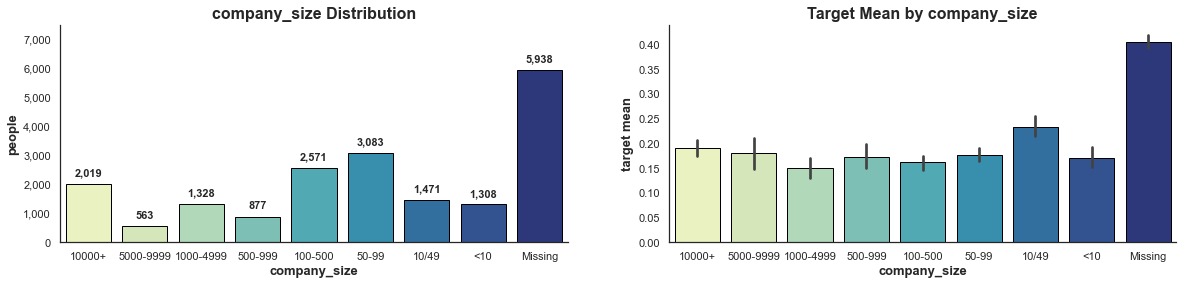

In [18]:
# 다음은 company_size 입니다.
show_categorical_feature(
    trn, 'company_size', order=company_size_order,
    figsize=(20, 4)
)

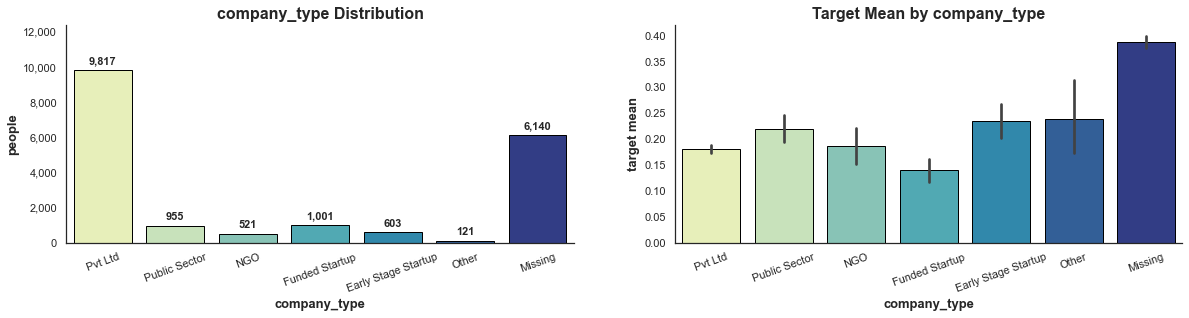

In [19]:
# 다음은 company_type 입니다.
show_categorical_feature(trn, 'company_type', order=company_type_order, rotation = 20, figsize=(20, 4))

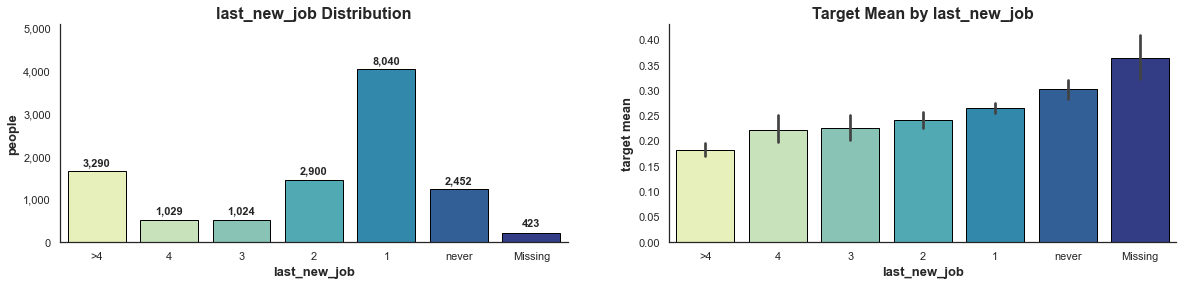

In [20]:
# 다음은 last_new_job 입니다.
show_categorical_feature(trn, 'last_new_job', ['>4', '4', '3', '2', '1', 'never', 'Missing'], figsize=(20, 4))

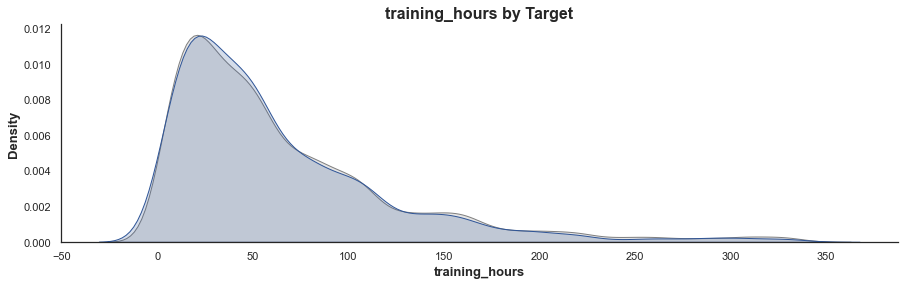

In [21]:
# 마지막으로 training_hours 입니다.
fig, ax = plt.subplots(figsize=(15, 4))
sns.kdeplot(data=trn[trn.target==0], x='training_hours', label='target:0', ax=ax, fill=True, color='grey', alpha=0.2)
sns.kdeplot(data=trn[trn.target==1], x='training_hours', label='target:1', ax=ax, fill=True, color='#2f5597', alpha=0.2)
ax.set_title('training_hours by Target')
plt.show()
# 거의 차이가 없습니다.

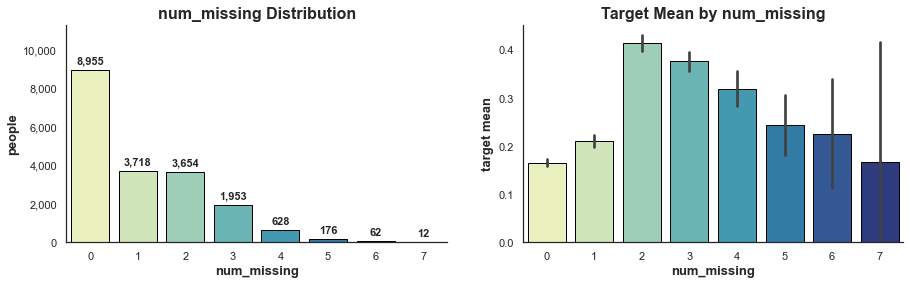

In [22]:
# 그래프를 쭉 보니 Missing의 Target Mean이 높습니다. Missing이 몇개인지에 따라 Target mean 이 어떻게 달라지는지 확인해보겠습니다.
trn['num_missing'] = (trn=='Missing').sum(axis=1)
show_categorical_feature(trn, 'num_missing')
# Missing 값이 몇개인지에 따라 유의미한 차이가 있습니다. 이 Feature도 모델링에 사용하겠습니다.